In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import random


# Tumors in Rats

In [2]:
data1 = pd.read_csv("/Users/brianxiang/Downloads/data.final.2024.Q3.csv")

## Data and Set Up

We are measuring tumor incidence in rats across 15 different experiments. Our data consists of $n_i = $ the number of rats in each experiment $i$ and $y_i = $ the number of those rats that had tumors.

We design a Beta-Binomial hierarchical model as follows:

$$y_i \sim Bin(n_i, \theta_i)$$

$$\theta_i \sim Beta(\alpha, \beta)$$

with noninformative prior $p(\alpha, \beta) \propto 1$.

This gives us the following conditional distributions:

$$\theta_i | y_i, \alpha, \beta \sim Beta(y_i + \alpha, n_i - y_i + \beta)$$

$$p(\alpha, \beta | y, \theta) \propto (\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)})^{15}\prod_{i = 1}^{15}\theta_i^\alpha(1 - \theta_i)^\beta \Rightarrow$$

$$\ln(p(\alpha, \beta | y, \theta)) \propto -15\ln(\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}) + \sum_{i = 1}^{15} \alpha \ln(\theta_i) + \beta \ln(1 - \theta_i)$$

We use a Gibbs sampler with a Metropolis step to sample from the joint posterior distribution $\theta, \alpha, \beta | y$ using normal proposal distributions $\alpha^* \sim Norm(\alpha^{t - 1}. \nu_\alpha), \beta^* \sim Norm(\beta^{t - 1}. \nu_\beta)$ for each iteration $t$ with tuning parameter $\nu_\alpha, \nu_\beta$.



### Initial Values and Tuning Parameters

We use two chain with inital values:

$$\alpha_1^{(0)} = 1, \beta_1^{(0)} = 2, \theta_{1i}^{(0)} \sim Beta(y_i + 1, n_i - y_i + 2)$$

and 

$$\alpha_2^{(0)} = 20, \beta_2^{(0)} = 50, \theta_{2i}^{(0)} \sim Beta(y_i + 20, n_i - y_i + 50)$$

We use tuning parameters $\nu_\alpha = 0.3, \nu_\beta = 1.1$ which were determined based on the acceptance rate ($\sim$75%).

# Total Traffic Data

In [3]:
data2 = pd.read_table("/Users/brianxiang/Downloads/bicycles-1.txt", sep = '\s+', header = 0)

Determine the amount of traffic on each street.

$$y_i \sim Poisson(\theta_i)$$
$$\theta_i \sim Gamma(\alpha, \beta)$$
$$p(\alpha, \beta) \propto 1$$

Poisson-Gamma HM

# Useful Functions

In [285]:
def maximal_coupling(mu_x, mu_y, prv, qrv, log_p, log_q, tuning):
    x_prop = prv()
    
    if np.log(random.uniform(0, 1)) <= log_q(x_prop) - log_p(x_prop):
        return x_prop, x_prop
    else:
        y_prop = qrv()
        while np.log(random.uniform(0, 1)) <= log_p(y_prop) - log_q(y_prop):
            y_prop = qrv()
            
        return x_prop, y_prop


In [305]:
#qrv, log_q are not used, they are here for style

def reflective_coupling(mu_x, mu_y, prv, qrv, log_p, log_q, tuning):
    Delta = 1 / np.sqrt(tuning) * (mu_x - mu_y)
    e = 1
    if len(np.array([Delta]).ravel()) > 1:
        e = Delta / np.sqrt(np.sum(np.power(Delta, 2)))

    x_dot = prv()
    if np.log(random.uniform(0, 1)) <= log_p(x_dot + Delta) - log_p(x_dot):
        y_dot = x_dot + Delta
        
        return np.sqrt(tuning) * x_dot + mu_x, np.sqrt(tuning) * y_dot + mu_y
    else:
        y_dot = x_dot - 2 * x_dot
        
        if len(np.array([Delta]).ravel()) > 1:
            y_dot = x_dot - 2 * np.dot(e, x_dot) * e

        return np.sqrt(tuning) * x_dot + mu_x, np.sqrt(tuning) * y_dot + mu_y
        

In [287]:
def ar(prev, prop, crit, log_pdf):
    log_r = log_pdf(prop) - log_pdf(prev)
    if crit <= log_r:
        return prop
    else:
        return prev

In [288]:
def equality(px, py):
    if all (px == py):
        return True
    else:
        return False

In [289]:
def log_bb(data, params):
    if any(params <= 0) or any(params[2:] > 1):
        return -float("inf")
    else:
        return -len(data[0]) * np.log(scipy.special.beta(params[0], params[1])) + np.sum((data[0] + params[0] - 1) * np.log(params[2:])) + np.sum((data[1] - data[0] + params[1] - 1) * np.log(1 - params[2:]))
        

In [11]:
def log_pg(data, params):
    if any(params <= 0):
        return -float("inf")
    else:
        n = len(data)
        return params[0] * n * np.log(params[1]) - n * scipy.special.gammaln(params[0]) + np.sum((params[0] + data - 1) * np.log(params[2:])) - np.sum((params[1] + 1) * params[2:])




In [12]:
def log_ab(data, params):
    if any(params[-1] <= 0):
        return -float("inf")
    else:
        return -15 * np.log(scipy.special.beta(params[-1][0], params[-1][1])) + params[-1][0] * np.sum(np.log(params[0])) + params[-1][1] * np.sum(np.log(1 - params[0]))

In [15]:
def adaptive_converge1(px, py, Gx, Gy, sx, sy, eps, thresh):
    lx = Gx + eps
    ly = Gy + eps
    if all(px == py) and all(np.ravel(np.abs(np.exp(2 * sx) * lx - np.exp(2 * sy) * ly)) < thresh):
        return True
    else:
        return False

In [16]:
def adaptive_converge2(px, py, Gx, Gy, sx, sy, eps, thresh):
    lx = Gx + eps
    ly = Gy + eps
    if all(px == py) and all(np.ravel(np.abs((np.exp(2 * sx) * lx) / (np.exp(2 * sy) * ly))) < (1 + thresh)) and all(np.ravel(np.abs((np.exp(2 * sx) * lx) / (np.exp(2 * sy) * ly))) > (1 - thresh)):
        return True
    else:
        return False

# Unbiased Method \#1

Fully Metropolis

In [261]:
def coupled_metropolis1(data, x_init, y_init, converge_fun, coupling_fun, logpdf_fun, tuning, k = 100, lag = 1, maximum_iteration = 10000):
    
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]
    
    iteration = 0
    
    logpdf = lambda z: logpdf_fun(data, z)
    
    while not converge_fun(params_x[-1], params_y[-1]):
        if lag <= iteration:
            prev_x = params_x[-1]
            prev_y = params_y[-1]
            
            x_rv = lambda: scipy.stats.multivariate_normal.rvs(prev_x, tuning)
            y_rv = lambda: scipy.stats.multivariate_normal.rvs(prev_y, tuning)
            log_x = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_x, tuning)
            log_y = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_y, tuning)
            
            x_prop, y_prop = coupling_fun(prev_x, prev_y, x_rv, y_rv, log_x, log_y, tuning) 
                    
            log_u = np.log(random.uniform(0, 1))
            params_x.append(ar(params_x[-1], x_prop, log_u, logpdf))
            params_y.append(ar(params_y[-1], y_prop, log_u, logpdf))
        else:
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning)
            log_u = np.log(random.uniform(0, 1))
            params_x.append(ar(params_x[-1], x_prop, log_u, logpdf))
        
        iteration += 1
        
        if iteration == maximum_iteration:
            break
        
    print(iteration)
    
    if iteration != maximum_iteration:
        for i in range(k):
            x_prop = scipy.stats.multivariate_normal.rvs(params_x[-1], tuning)
            logu = np.log(random.uniform(0, 1))
            temp = ar(params_x[-1], x_prop, logu, logpdf)
            params_x.append(temp)
            params_y.append(temp)
        
    return params_x, params_y, iteration
    

## Rat

In [262]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis1(data, x_init, y_init, equality, maximal_coupling, log_bb, tuning = np.array([0.3, 1.1] + [0.01] * len(y)))


10000


In [263]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

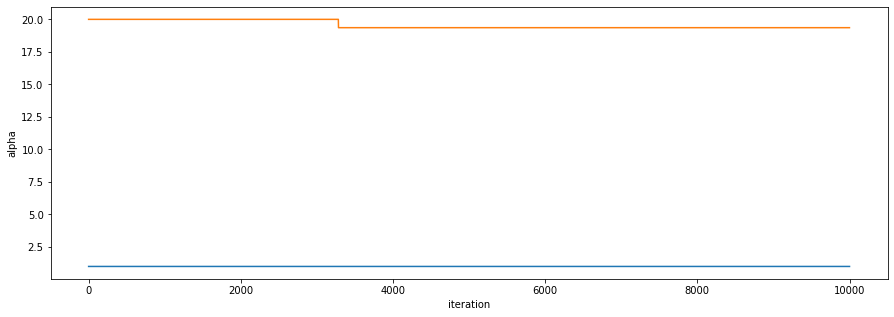

In [264]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

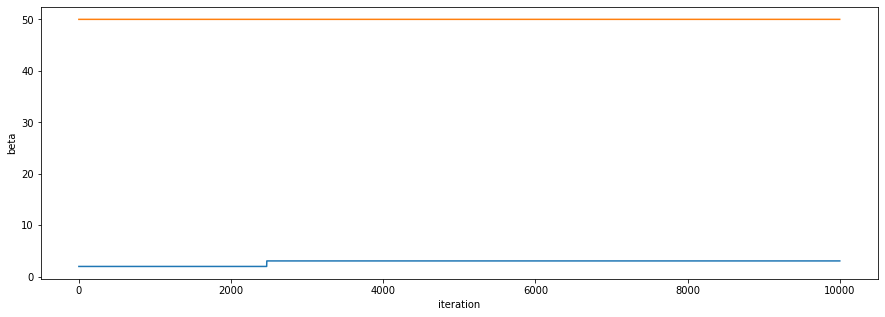

In [21]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

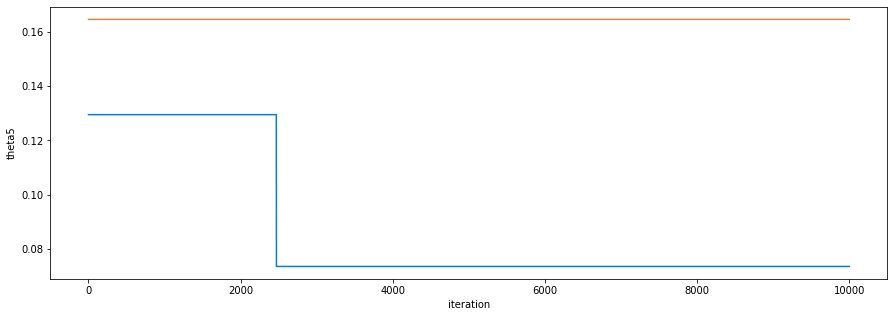

In [22]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Traffic

In [23]:
y = data2.iloc[2, 2:12].astype(int).to_numpy() + data2.iloc[2, 12:22].astype(int).to_numpy()
data = y

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis1(data, x_init, y_init, equality, maximal_coupling, log_pg, tuning = np.array([0.3, 0.3] + [10] * len(y)))


10000


In [24]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

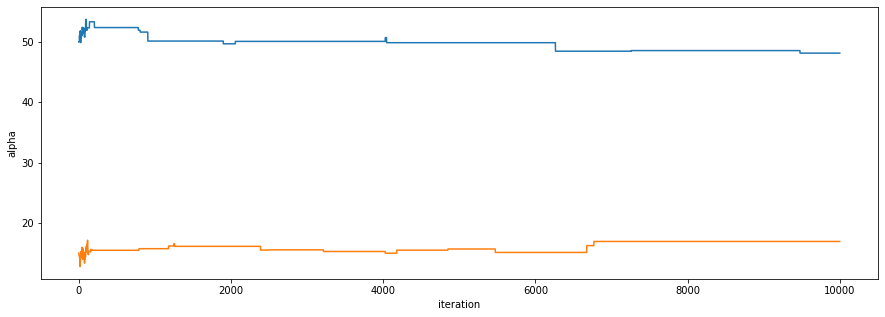

In [25]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

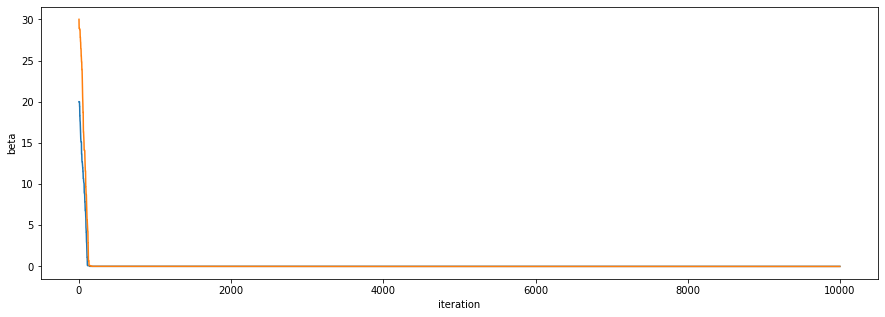

In [26]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

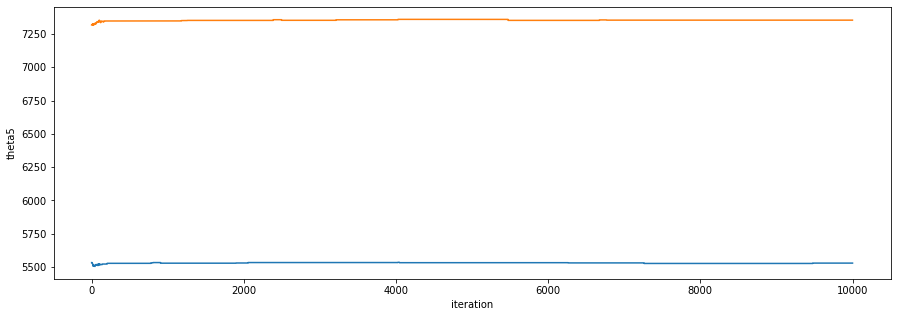

In [27]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Unbiased Method \#2

Metropolis step within Gibbs sampler

In [290]:
def coupled_metropolis2(data, x_init, y_init, converge_fun, coupling_fun, logpdf_fun, tuning, k = 100, lag = 1, maximum_iteration = 10000):

    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]
    
    iteration = 0
    
    while not converge_fun(params_x[-1], params_y[-1]):
        if lag <= iteration:
            x_prop = np.zeros(len(params_x[-1]))
            y_prop = np.zeros(len(params_x[-1]))

            for j in range(len(x_prop)):
                prev_x = params_x[-1][j]
                prev_y = params_y[-1][j]
                
                x_rv = lambda: scipy.stats.norm.rvs(prev_x, np.sqrt(tuning[j]))
                y_rv = lambda: scipy.stats.norm.rvs(prev_y, np.sqrt(tuning[j]))
                log_x = lambda z: scipy.stats.norm.logpdf(z, prev_x, np.sqrt(tuning[j]))
                log_y = lambda z: scipy.stats.norm.logpdf(z, prev_y, np.sqrt(tuning[j]))
                
                temp_x, temp_y = coupling_fun(prev_x, prev_y, x_rv, y_rv, log_x, log_y, tuning[j])
                
                log_u = np.log(random.uniform(0, 1))
                x_prop[j] = ar(params_x[-1][j], temp_x, log_u, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))
                y_prop[j] = ar(params_y[-1][j], temp_y, log_u, lambda z: logpdf_fun(data, np.hstack((params_y[-1][:j], z, params_y[-1][j + 1:]))))
            
            params_x.append(x_prop)
            params_y.append(y_prop)

        else:
            x_prop = np.zeros(len(params_x[-1]))
            
            for j in range(len(x_prop)):
                temp_x = scipy.stats.norm.rvs(params_x[-1][j], np.sqrt(tuning[j]))
                
                log_u = np.log(random.uniform(0, 1))
                x_prop[j] = ar(params_x[-1][j], temp_x, log_u, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))

            params_x.append(x_prop)
            
        iteration += 1
        if iteration == maximum_iteration:
            break
        
    print(iteration)

    if iteration != maximum_iteration:
        for i in range(k):
            x_prop = np.zeros(len(params_x[-1]))
            
            for j in range(len(x_prop)):
                temp_x = scipy.stats.norm.rvs(params_x[-1][j], np.sqrt(tuning[j]))
                
                log_u = np.log(random.uniform(0, 1))
                x_prop[j] = ar(params_x[-1][j], temp_x, log_u, lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:]))))
    
            params_x.append(x_prop)
            params_y.append(x_prop)
        
    return params_x, params_y, iteration
    

## Rat

In [291]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, equality, maximal_coupling, log_bb, tuning = np.array([0.3, 1.1] + [0.01] * 15), k = 1000)


342


In [292]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

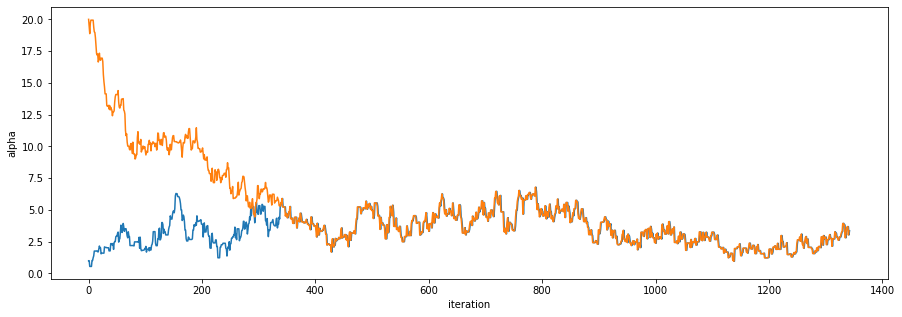

In [293]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

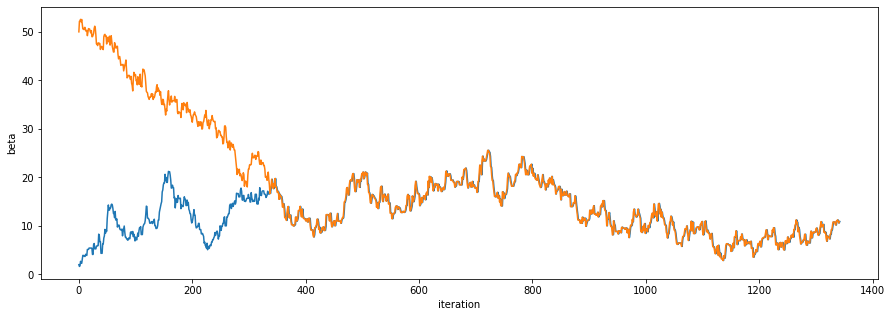

In [294]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

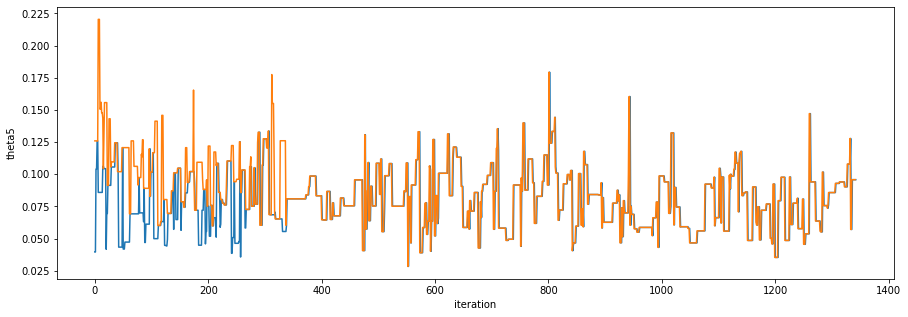

In [295]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Traffic

In [34]:
y = data2.iloc[2, 2:12].astype(int).to_numpy() + data2.iloc[2, 12:22].astype(int).to_numpy()

data = y

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, equality, maximal_coupling, log_pg, tuning = np.array([2.7, 0.3] + [500] * len(y)))


6378


In [35]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

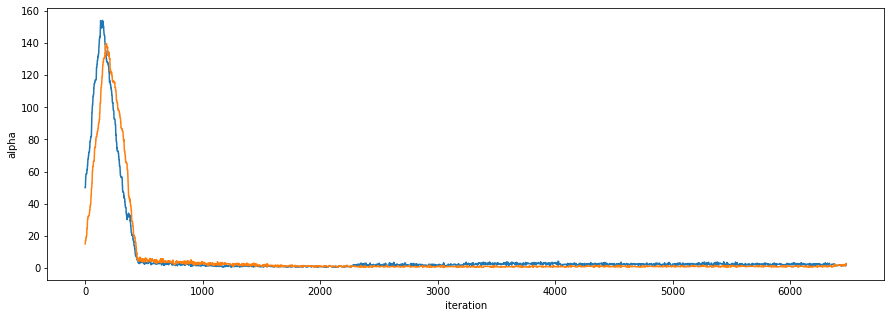

In [36]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

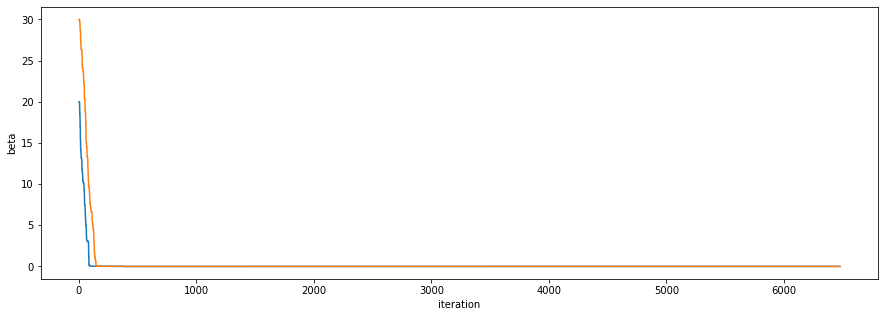

In [37]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

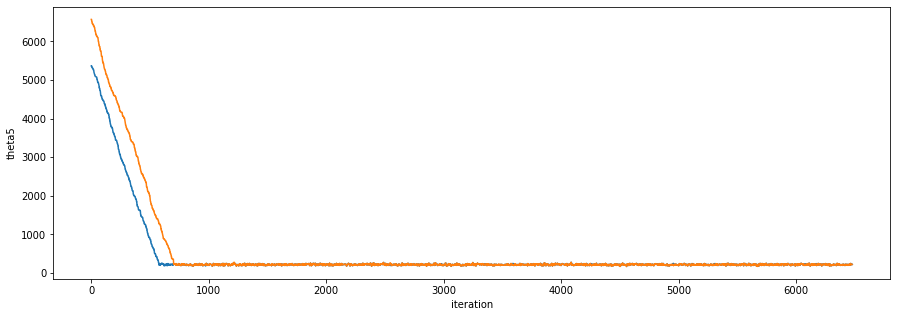

In [38]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Unbiased Method \#3 

Gibbs sampler, difficult to do since the coupling is not generalizable

In [248]:
def coupled_gibbs_rat(data, x_init, y_init, converge_fun, coupling_fun, logpdf_fun, tuning, k = 100, lag = 1, maximum_iteration = 10000):

    params_x = [x_init]
    params_y = [y_init]
    
    iteration = 0

    while not converge_fun(params_x[-1][-1], params_y[-1][-1]):
        if lag <= iteration:
            temp_x = np.zeros(len(x_init), dtype = 'object')
            temp_y = np.zeros(len(x_init), dtype = 'object')

            x_prop = np.zeros(len(params_x[-1][0]))
            y_prop = np.zeros(len(params_y[-1][0]))
            
            for j in range(15):
                x_rv = lambda: scipy.stats.beta.rvs(data[0][j] + params_x[-1][-1][0], data[1][j] - data[0][j] + params_x[-1][-1][1])
                y_rv = lambda: scipy.stats.beta.rvs(data[0][j] + params_y[-1][-1][0], data[1][j] - data[0][j] + params_y[-1][-1][1])
                log_x = lambda z: scipy.stats.beta.logpdf(z, data[0][j] + params_x[-1][-1][0], data[1][j] - data[0][j] + params_x[-1][-1][1])
                log_y = lambda z: scipy.stats.beta.logpdf(z, data[0][j] + params_y[-1][-1][0], data[1][j] - data[0][j] + params_y[-1][-1][1])
                
                x_prop[j], y_prop[j] = coupling_fun(prev_x, prev_y, x_rv, y_rv, log_x, log_y, 0)
            
            temp_x[0] = x_prop
            temp_y[0] = y_prop
                
            x_prop = np.zeros(len(params_x[-1][-1]))
            y_prop = np.zeros(len(params_x[-1][-1]))
            
            for j in range(len(x_prop)):
                prev_x = params_x[-1][-1][j]
                prev_y = params_y[-1][-1][j]

                x_rv = lambda: scipy.stats.norm.rvs(prev_x, np.sqrt(tuning[j]))
                y_rv = lambda: scipy.stats.norm.rvs(prev_y, np.sqrt(tuning[j]))
                log_x = lambda z: scipy.stats.norm.logpdf(z, prev_x, np.sqrt(tuning[j]))
                log_y = lambda z: scipy.stats.norm.logpdf(z, prev_y, np.sqrt(tuning[j]))

                temp_x_prop, temp_y_prop = coupling_fun(prev_x, prev_y, x_rv, y_rv, log_x, log_y, tuning[j])
                
                log_u = np.log(random.uniform(0, 1))
                x_prop[j] = ar(prev_x, temp_x_prop, log_u, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
                y_prop[j] = ar(prev_y, temp_y_prop, log_u, lambda z: logpdf_fun(data, np.array(list(params_y[-1][:-1]) + [np.hstack((params_y[-1][-1][:j], z, params_y[-1][-1][j + 1:]))], dtype = 'object')))
            
            temp_x[-1] = x_prop
            temp_y[-1] = y_prop
            
            params_x.append(temp_x)
            params_y.append(temp_y)

        else:
            temp_x = np.zeros(len(x_init), dtype = 'object')

            x_prop = np.zeros(len(params_x[-1][0])) # 15
            
            for j in range(15):
                x_prop[j] = scipy.stats.beta.rvs(data[0][j] + params_x[-1][-1][0], data[1][j] - data[0][j] + params_x[-1][-1][1])
            
            temp_x[0] = x_prop
            
            x_prop = np.zeros(len(params_x[-1][-1]))

            for j in range(len(x_prop)):
                prev_x = params_x[-1][-1][j]

                temp_x_prop = scipy.stats.norm.rvs(prev_x, np.sqrt(tuning[j]))

                log_u = np.log(random.uniform(0, 1))
                x_prop[j] = ar(prev_x, temp_x_prop, log_u, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
            
            temp_x[-1] = x_prop
            
            params_x.append(temp_x)            
            
        iteration += 1
        if iteration == maximum_iteration:
            break
        
    print(iteration)

    if iteration != maximum_iteration:
        for i in range(k):
            temp_x = np.zeros(len(x_init), dtype = 'object')

            x_prop = np.zeros(len(params_x[-1][0])) # 15
            
            for j in range(15):
                x_prop[j] = scipy.stats.beta.rvs(data[0][j] + params_x[-1][-1][0], data[1][j] - data[0][j] + params_x[-1][-1][1])
            
            temp_x[0] = x_prop
            
            x_prop = np.zeros(len(params_x[-1][-1]))

            for j in range(len(x_prop)):
                prev_x = params_x[-1][-1][j]

                temp_x_prop = scipy.stats.norm.rvs(prev_x, np.sqrt(tuning[j]))

                log_u = np.log(random.uniform(0, 1))
                x_prop[j] = ar(prev_x, temp_x_prop, log_u, lambda z: logpdf_fun(data, np.array(list(params_x[-1][:-1]) + [np.hstack((params_x[-1][-1][:j], z, params_x[-1][-1][j + 1:]))], dtype = 'object')))
            
            temp_x[-1] = x_prop
            
            params_x.append(temp_x) 
            params_y.append(temp_x) 

    return params_x, params_y, iteration
    

## Rat

In [52]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.array((theta_1, np.array([a_1, b_1])), dtype = 'object')
y_init = np.array((theta_2, np.array([a_2, b_2])), dtype = 'object')

thetas = lambda data, params: np.random.beta(data[0] + params[-1][0], data[1] - data[0] + params[-1][1])
theta_pdf = lambda z: scipy.stats.beta.logpdf(z, data[0] + params[-1][0], data[1] - data[0] + params[-1][1])

gibbs_sampler = [thetas]
gibbs_eval = [theta_pdf]

params_x, params_y, iteration = coupled_gibbs_rat(data, x_init, y_init, equality, maximal_coupling, log_ab, tuning = np.array([0.3, 1.1]), k = 1000)


670


In [53]:
chain1_df = pd.DataFrame([np.hstack(x) for x in params_x], columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15', 'alpha', 'beta'])
chain2_df = pd.DataFrame([np.hstack(y) for y in params_y], columns = ['theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15', 'alpha', 'beta'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

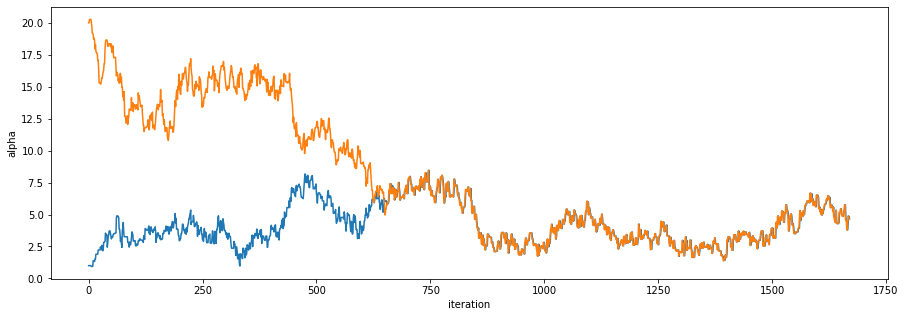

In [54]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

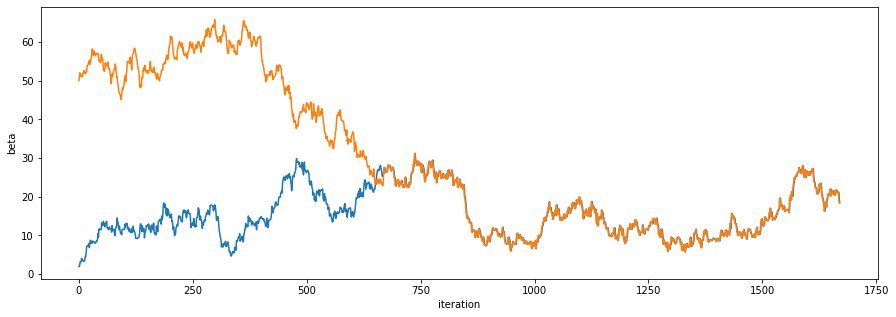

In [55]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

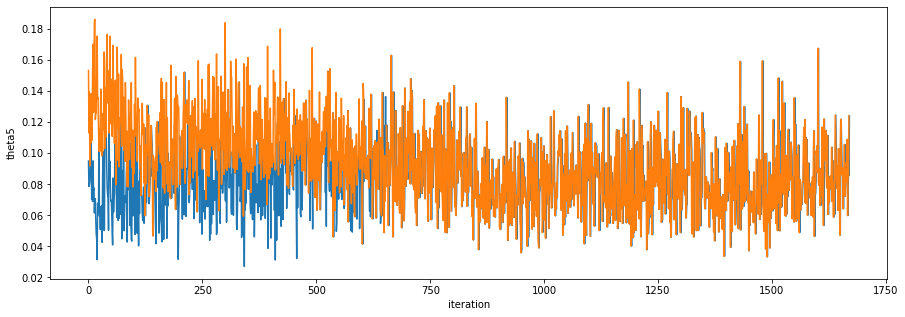

In [56]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

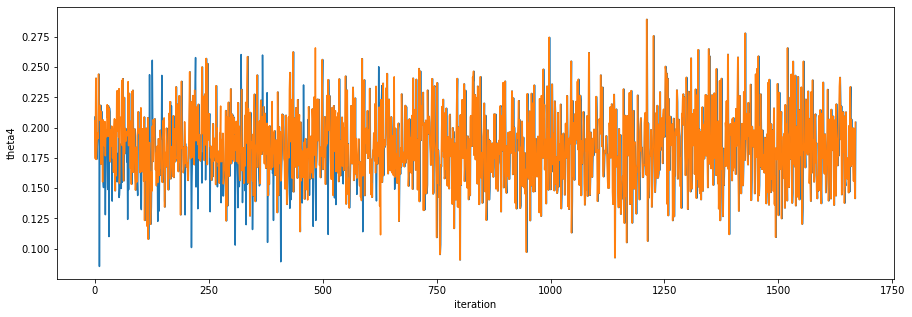

In [57]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta4', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta4', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Separate Adaptive MCMC

In [60]:
# For fully Metropolis
def adaptive_metro1(data, init, logpdf_fun, eps = 0.01, max_iteration = 100000):
    params = [np.array(init)]
    accept = 1
    total = 1
    
    iteration = 0
    mu = params[-1]
    
    Gamma = np.zeros((len(params[-1]), len(params[-1])))
                     
    sigma = 0.7

    n = 0
    gamma = 1
    
    logpdf = lambda z: logpdf_fun(data, z)
    
    for _ in range(max_iteration):
        lamb = Gamma + eps * np.eye(len(Gamma))

        prop = np.random.multivariate_normal(mean = params[-1], cov = np.exp(2 * sigma) * lamb)

        log_u = np.log(random.uniform(0, 1))

        log_r = min(0, logpdf(prop) - logpdf(params[-1]))

        if log_u <= log_r:
            accept += 1
            params.append(prop)
        else:
            params.append(params[-1])

        n += 1

        m = params[-1] - mu
        Gamma = Gamma + (np.matmul(np.atleast_2d(m).T, np.atleast_2d(m)) - Gamma) / n

        mu = mu + (params[-1] - mu) / n

        gamma = np.sqrt(1/n)
        sigma = sigma + gamma * (np.exp(log_r) - 0.3)
    
    return params, mu, Gamma, sigma, iteration, accept/total
    

In [69]:
# For Metropolis within Gibbs

def adaptive_metro2(data, init, logpdf_fun, eps = 0.01, max_iteration = 10000):
    params = [np.array(init)]
    accept = 1
    total = 1
    
    iteration = 0
    mu = params[-1]
    
    Gamma = np.zeros(len(params[-1]))
    sigma = np.ones(len(params[-1])) * 0.7

    n = 0
    gamma = 1
    
    for _ in range(max_iteration):
        temp = np.zeros(len(params[-1]))
        log_r = np.zeros(len(params[-1]))
        
        for j in range(len(params[-1])):
            lamb = Gamma[j] + eps
            logpdf = lambda z: logpdf_fun(data, np.hstack((params[-1][:j], z, params[-1][j + 1:])))
            prop = np.random.normal(params[-1][j], np.sqrt(np.exp(2 * sigma[j]) * lamb))

            log_u = np.log(random.uniform(0, 1))
            log_r[j] = min(0, logpdf(prop) - logpdf(params[-1][j]))


            if log_u <= log_r[j]:
                accept += 1
                temp[j] = prop
            else:
                temp[j] = params[-1][j]

        params.append(temp)

        total += len(params[-1])
        n += 1

        m = params[-1] - mu
        Gamma = Gamma + (np.power(m, 2) - Gamma) / n
        
        mu = mu + (params[-1] - mu)/n

        gamma = np.sqrt(1/n)
        sigma = sigma + gamma * (np.exp(log_r) - 0.3)

        iteration += 1

        if iteration == 100000:
            break

        
    print(iteration)
    
    return params, mu, Gamma, sigma, iteration, accept/total
    

## Rat

### Fully Metropolis

In [97]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params, mu, tuning, c, iteration, rate = adaptive_metro1(data, x_init, log_bb)

In [98]:
chain_df = pd.DataFrame(params, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain_df = chain_df.reset_index().rename(columns = {'index': 'iteration'})


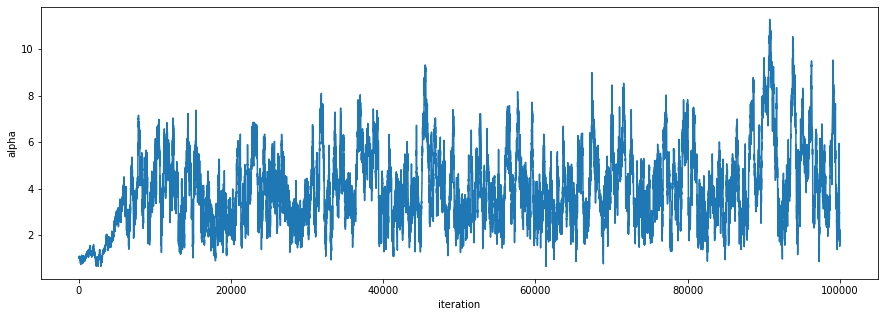

In [99]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

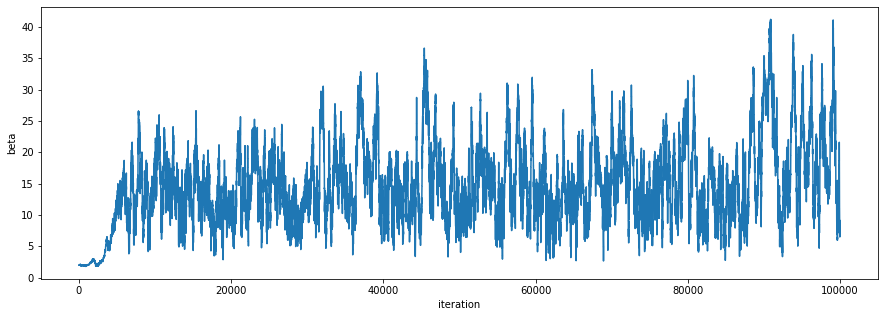

In [100]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

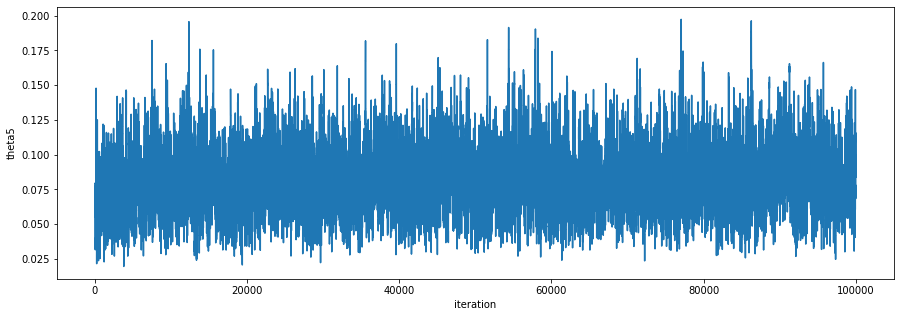

In [101]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [107]:
lamb = tuning + 0.01 * np.eye(len(tuning))

params_x, params_y, iteration = coupled_metropolis1(data, x_init, y_init, equality, maximal_coupling, log_bb, tuning = np.exp(2 * c) * lamb, k = 10000, maximum_iteration = 100000)

100000


In [108]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

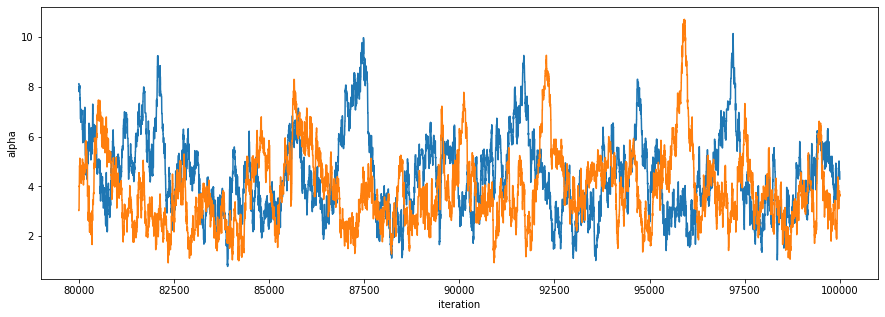

In [109]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

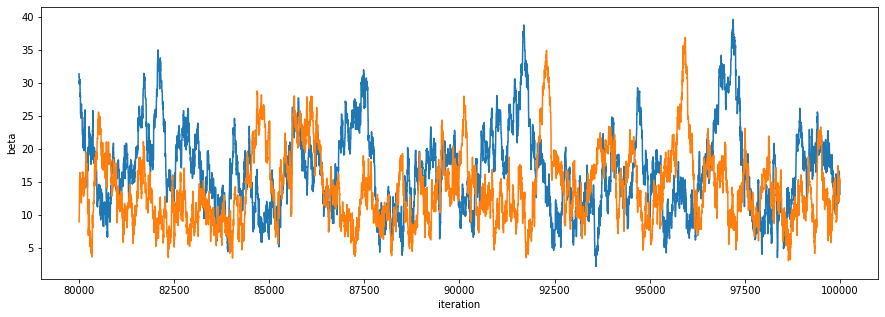

In [110]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

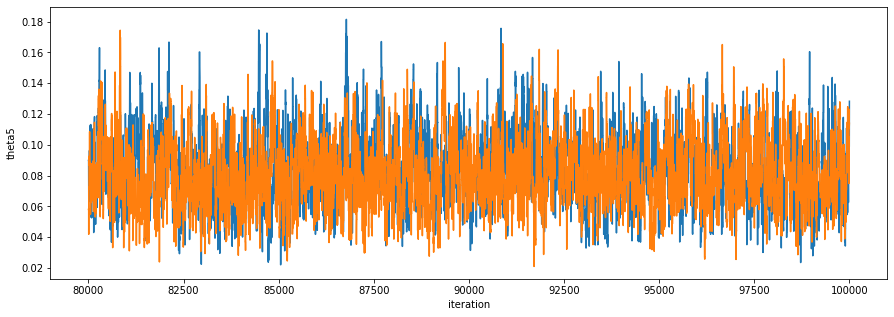

In [111]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

### Metropolis within Gibbs

In [112]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params, mu, tuning, c, iteration, rate = adaptive_metro2(data, x_init, log_bb, max_iteration = 100000)

100000


In [113]:
lamb = tuning + 0.01

params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, equality, maximal_coupling, log_bb, tuning = np.exp(2 * c) * lamb, k = 10000)


125


In [114]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

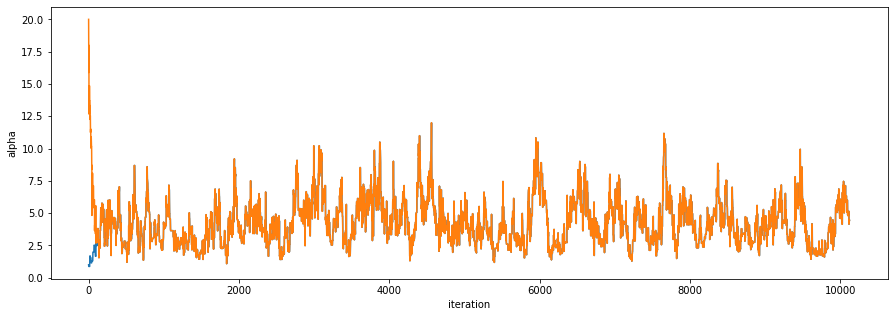

In [115]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

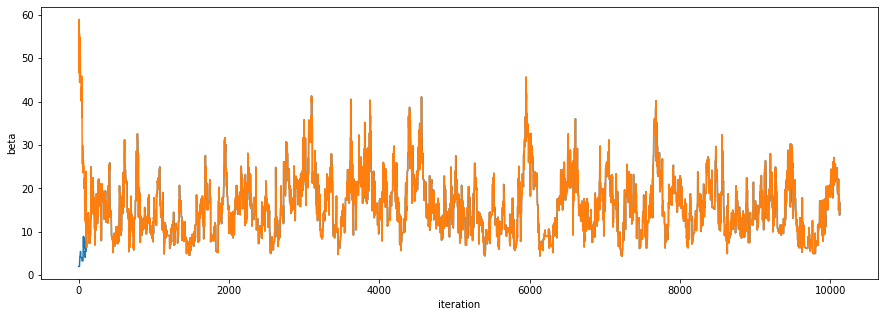

In [116]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

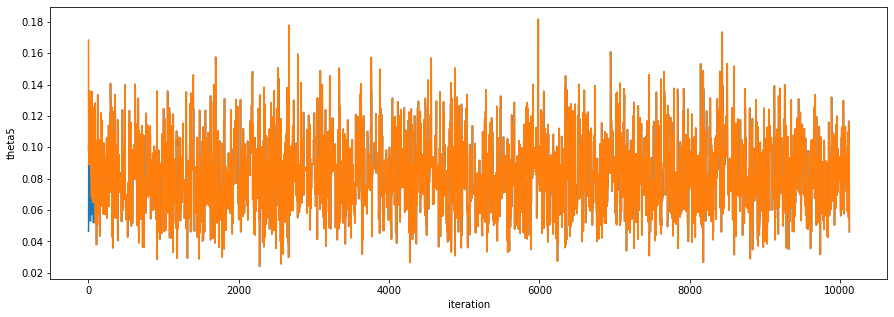

In [117]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Traffic

### Fully Metropolis

In [118]:
y = data2.iloc[2, 2:12].astype(int).to_numpy() + data2.iloc[2, 12:22].astype(int).to_numpy()
data = y

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params, mu, tuning, c, iteration, rate = adaptive_metro1(data, y_init, log_pg)


In [120]:
lamb = tuning + 0.1 * np.eye(len(tuning))

params_x, params_y, iteration = coupled_metropolis1(data, x_init, y_init, equality, maximal_coupling, log_pg, tuning = np.exp(2 * c) * lamb, k = 10000, maximum_iteration = 100000)


100000


In [121]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

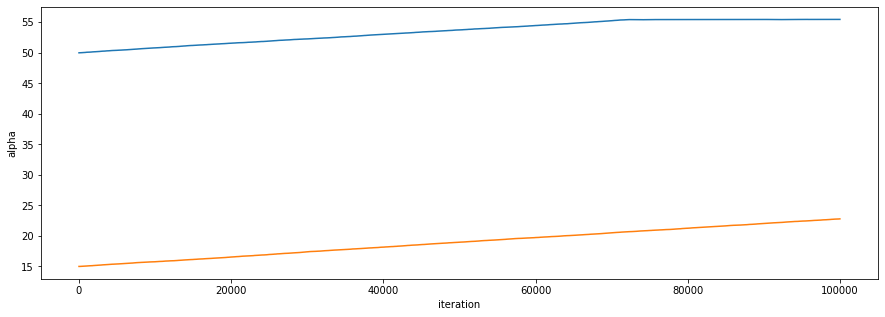

In [122]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

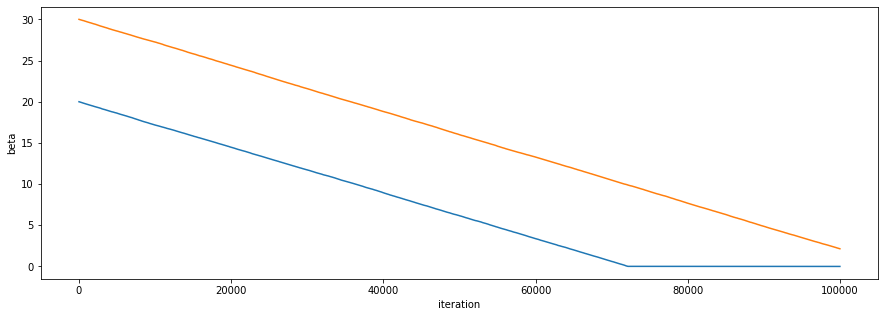

In [123]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

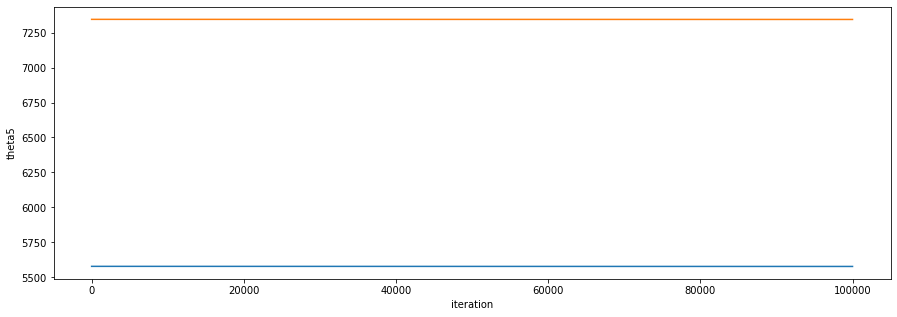

In [124]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

### Metropolis within Gibbs

In [136]:
y = data2.iloc[2, 2:12].astype(int).to_numpy() + data2.iloc[2, 12:22].astype(int).to_numpy()

data = y

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params, mu, tuning, c, iteration, rate = adaptive_metro2(data, y_init, log_pg, max_iteration = 100000)


100000


In [137]:
chain_df = pd.DataFrame(params, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain_df = chain_df.reset_index().rename(columns = {'index': 'iteration'})

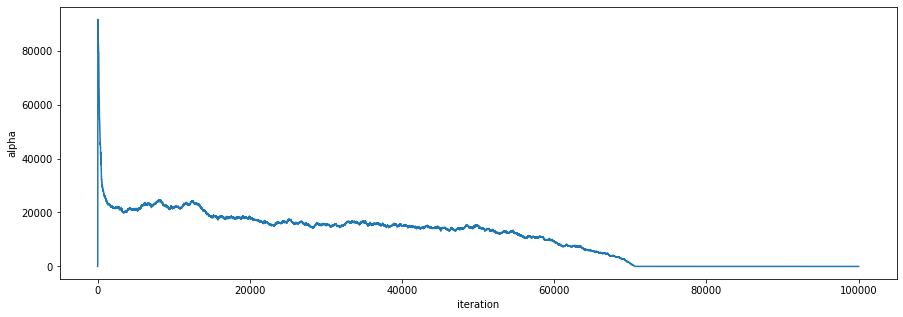

In [138]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

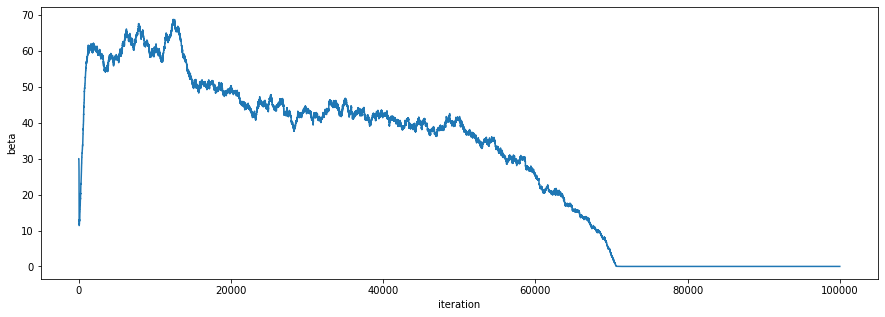

In [139]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

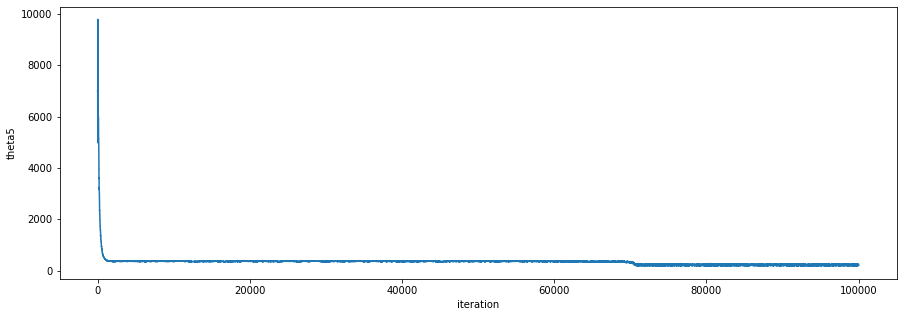

In [140]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

In [141]:
data = y

a_1 = 50
b_1 = 20
theta_1 = np.random.gamma(50 + y, 21, len(y))

a_2 = 15
b_2 = 30
theta_2 = np.random.gamma(15 + y, 31, len(y))

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

lamb = tuning + 0.01

params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, equality, maximal_coupling, log_pg, tuning = np.sqrt(np.exp(2 * c[-1]) * lamb))


10000


In [142]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

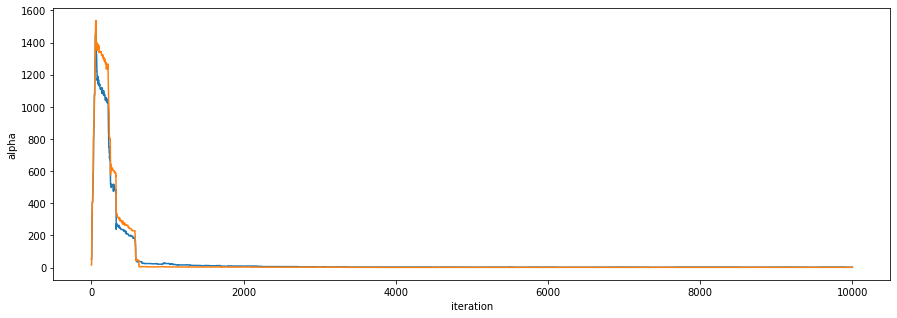

In [143]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

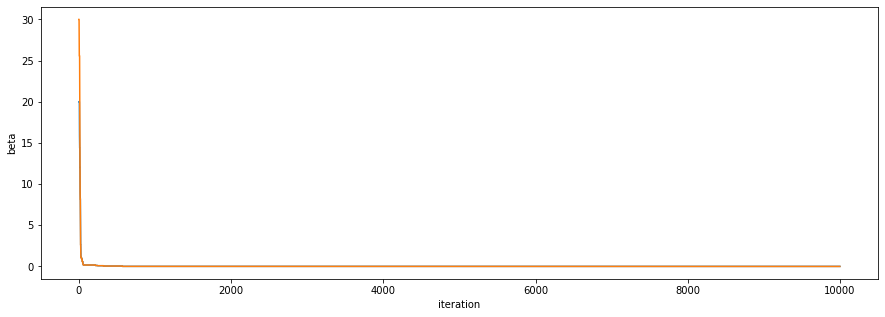

In [144]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

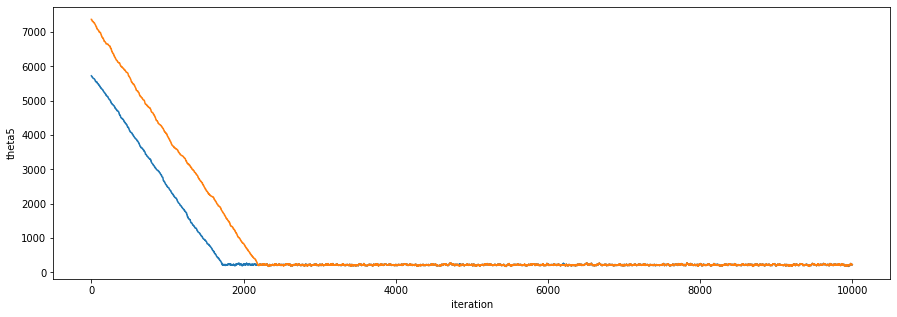

In [145]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Controlled Bias Adaptive MCMC (put this in the closet)

## Metropolis

In [158]:
def coupled_adaptive_metropolis1(data, x_init, y_init, converge_fun, coupling_fun, logpdf_fun, eps = 0.01, k = 100, lag = 1, maximum_iteration = 10000):
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]

    mu_x = params_x[-1]
    Gamma_x = np.zeros((len(params_x[-1]), len(params_x[-1])))
    sigma_x = 0.7
    nx = 0
    gamma_x = 1

    mu_y = params_y[-1]
    Gamma_y = np.zeros((len(params_y[-1]), len(params_y[-1])))
    sigma_y = 0.7
    ny = 0
    gamma_y = 1
    
    iteration = 0
    
    logpdf = lambda z: logpdf_fun(data, z)
    
    while not converge_fun(params_x[-1], params_y[-1], Gamma_x, Gamma_y, sigma_x, sigma_y, eps, 1):
        if lag <= iteration:
            lamb_x = Gamma_x + eps * np.eye(len(Gamma_x))
            lamb_y = Gamma_y + eps * np.eye(len(Gamma_y))
            tuning_x = np.exp(2 * sigma_x) * lamb_x
            tuning_y = np.exp(2 * sigma_y) * lamb_y

            prev_x = params_x[-1]
            prev_y = params_y[-1]
            
            x_rv = lambda: scipy.stats.multivariate_normal.rvs(prev_x, tuning_x)
            y_rv = lambda: scipy.stats.multivariate_normal.rvs(prev_y, tuning_y)
            log_x = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_x, tuning_x)
            log_y = lambda z: scipy.stats.multivariate_normal.logpdf(z, prev_y, tuning_y)
            
            x_prop, y_prop = coupling_fun(x_rv, y_rv, log_x, log_y) 

            log_u = np.log(random.uniform(0, 1))

            
            log_rx = min(0, logpdf(x_prop) - logpdf(prev_x))
            log_ry = min(0, logpdf(y_prop) - logpdf(prev_y))
    
            if log_u <= log_rx:
                params_x.append(x_prop)
            else:
                params_x.append(prev_x)
    
            if log_u <= log_ry:
                params_y.append(y_prop)
            else:
                params_y.append(prev_y)
            
            nx += 1
            ny += 1
            
            m_x = params_x[-1] - mu_x
            Gamma_x = Gamma_x + (np.matmul(np.atleast_2d(m_x).T, np.atleast_2d(m_x)) - Gamma_x) / nx
    
            mu_x = mu_x + (params_x[-1] - mu_x) / nx
    
            gamma_x = np.sqrt(1/nx)
            sigma_x = sigma_x + gamma_x * (np.exp(log_rx) - 0.3)

            m_y = params_y[-1] - mu_y
            Gamma_y = Gamma_y + (np.matmul(np.atleast_2d(m_y).T, np.atleast_2d(m_y)) - Gamma_y) / ny
    
            mu_y = mu_y + (params_y[-1] - mu_y) / ny
    
            gamma_y = np.sqrt(1/ny)
            sigma_y = sigma_y + gamma_y * (np.exp(log_ry) - 0.3)

    
        else:
            lamb_x = Gamma_x + eps * np.eye(len(Gamma_x))
            tuning_x = np.exp(2 * sigma_x) * lamb_x

            prev_x = params_x[-1]
            
            x_prop = scipy.stats.multivariate_normal.rvs(prev_x, tuning_x)
            log_u = np.log(random.uniform(0, 1))

            
            log_rx = min(0, logpdf(x_prop) - logpdf(prev_x))
    
            if log_u <= log_rx:
                params_x.append(x_prop)
            else:
                params_x.append(prev_x)

            nx += 1
            
            m_x = params_x[-1] - mu_x
            Gamma_x = Gamma_x + (np.matmul(np.atleast_2d(m_x).T, np.atleast_2d(m_x)) - Gamma_x) / nx
    
            mu_x = mu_x + (params_x[-1] - mu_x) / nx
    
            gamma_x = np.sqrt(1/nx)
            sigma_x = sigma_x + gamma_x * (np.exp(log_rx) - 0.3)
                    
        iteration += 1
        
        if iteration == maximum_iteration:
            break
        
    print(iteration)

    if iteration != maximum_iteration:
        for i in range(k):
            lamb_x = Gamma_x + eps * np.eye(len(Gamma_x))
            tuning_x = np.exp(2 * sigma_x) * lamb_x

            prev_x = params_x[-1]
            
            x_prop = scipy.stats.multivariate_normal.rvs(prev_x, tuning_x)
            log_u = np.log(random.uniform(0, 1))

            
            log_rx = min(0, logpdf(x_prop) - logpdf(prev_x))
    
            if log_u <= log_rx:
                params_x.append(x_prop)
                params_y.append(x_prop)

            else:
                params_x.append(prev_x)
                params_y.append(prev_x)
        
    return params_x, params_y, iteration
    

In [159]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_adaptive_metropolis1(data, x_init, y_init, adaptive_converge2, maximal_coupling, log_bb, k = 10000, maximum_iteration = 100000)


100000


In [160]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

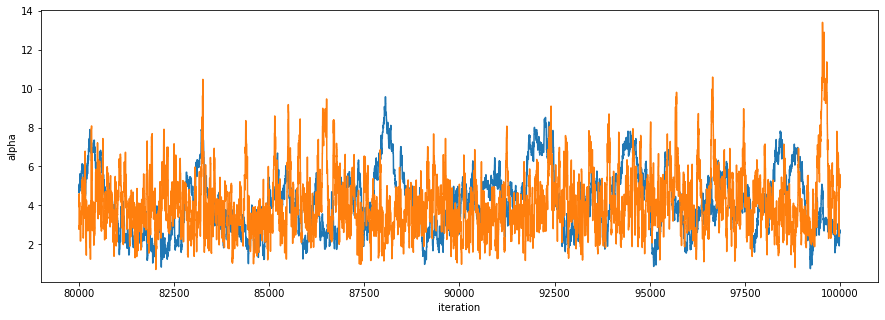

In [161]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

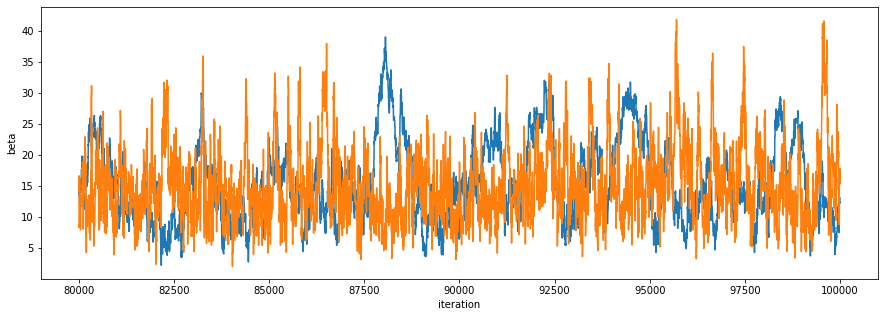

In [162]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

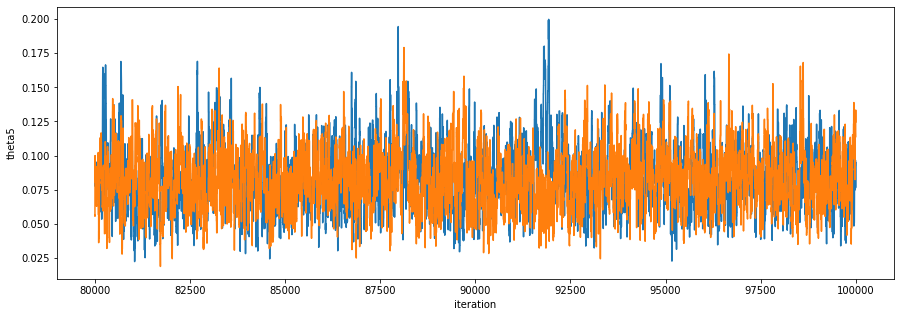

In [163]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

## Metropolis Gibbs

In [173]:
def coupled_adaptive_metropolis2(data, x_init, y_init, converge_fun, coupling_fun, logpdf_fun, eps = 0.01, k = 100, lag = 1, maximum_iteration = 10000):
    params_x = [np.array(x_init)]
    params_y = [np.array(y_init)]

    mu_x = params_x[-1]
    Gamma_x = np.zeros(len(params_x[-1]))
    sigma_x = np.ones(len(params_x[-1])) * 0.7
    nx = 0
    gamma_x = 1


    mu_y = params_y[-1]
    Gamma_y = np.zeros(len(params_y[-1]))
    sigma_y = np.ones(len(params_y[-1])) * 0.7
    ny = 0
    gamma_y = 1
    
    iteration = 0
    
    while not converge_fun(params_x[-1], params_y[-1], Gamma_x, Gamma_y, sigma_x, sigma_y, eps, 0.05):
        if lag <= iteration:
            lamb_x = Gamma_x + eps
            lamb_y = Gamma_y + eps

            tuning_x = np.exp(2 * sigma_x) * lamb_x
            tuning_y = np.exp(2 * sigma_y) * lamb_y

            x_prop = np.zeros(len(params_x[-1]))
            y_prop = np.zeros(len(params_x[-1]))

            log_rx = np.zeros(len(params_x[-1]))
            log_ry = np.zeros(len(params_y[-1]))

            for j in range(len(params_x[-1])):
                prev_x = params_x[-1][j]
                prev_y = params_y[-1][j]
                
                x_rv = lambda: scipy.stats.norm.rvs(prev_x, np.sqrt(tuning_x[j]))
                y_rv = lambda: scipy.stats.norm.rvs(prev_y, np.sqrt(tuning_y[j]))
                log_x = lambda z: scipy.stats.norm.logpdf(z, prev_x, np.sqrt(tuning_x[j]))
                log_y = lambda z: scipy.stats.norm.logpdf(z, prev_y, np.sqrt(tuning_y[j]))

                temp_x, temp_y = coupling_fun(x_rv, y_rv, log_x, log_y)

                
                logpdf_x = lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:])))
                logpdf_y = lambda z: logpdf_fun(data, np.hstack((params_y[-1][:j], z, params_y[-1][j + 1:])))
    
                log_u = np.log(random.uniform(0, 1))
    
                log_rx[j] = min(0, logpdf_x(temp_x) - logpdf_x(prev_x))
                log_ry[j] = min(0, logpdf_y(temp_y) - logpdf_y(prev_y))
    
                if log_u <= log_rx[j]:
                    x_prop[j] = temp_x
                else:
                    x_prop[j] = prev_x
    
                if log_u <= log_ry[j]:
                    y_prop[j] = temp_y
                else:
                    y_prop[j] = prev_y

            params_x.append(x_prop)
            params_y.append(y_prop)
    
            nx += 1
            ny += 1
    
            mx = params_x[-1] - mu_x
            Gamma_x = Gamma_x + (np.power(mx, 2) - Gamma_x) / nx
            mu_x = mu_x + (params_x[-1] - mu_x) / nx
            gamma_x = np.sqrt(1/nx)
            sigma_x = sigma_x + gamma_x * (np.exp(log_rx) - 0.3)
    
            my = params_y[-1] - mu_y
            Gamma_y = Gamma_y + (np.power(my, 2) - Gamma_y) / ny
            mu_y = mu_y + (params_y[-1] - mu_y) / ny
            gamma_y = np.sqrt(1/ny)
            sigma_y = sigma_y + gamma_y * (np.exp(log_ry) - 0.3)

    
        else:
            lamb_x = Gamma_x + eps
            tuning_x = np.exp(2 * sigma_x) * lamb_x
            
            x_prop = np.zeros(len(params_x[-1]))

            log_rx = np.zeros(len(params_x[-1]))

            for j in range(len(params_x[-1])):
                prev_x = params_x[-1][j]
                
                temp_x = scipy.stats.norm.rvs(prev_x, np.sqrt(tuning_x[j]))
                
                logpdf_x = lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:])))
    
                log_u = np.log(random.uniform(0, 1))
    
                log_rx[j] = min(0, logpdf_x(temp_x) - logpdf_x(prev_x))
    
                if log_u <= log_rx[j]:
                    x_prop[j] = temp_x
                else:
                    x_prop[j] = prev_x

            params_x.append(x_prop)
    
            nx += 1
    
            mx = params_x[-1] - mu_x
            Gamma_x = Gamma_x + (np.power(mx, 2) - Gamma_x) / nx
            mu_x = mu_x + (params_x[-1] - mu_x) / nx
            gamma_x = np.sqrt(1/nx)
            sigma_x = sigma_x + gamma_x * (np.exp(log_rx) - 0.3)
 
        iteration += 1
        
        if iteration == maximum_iteration:
            break
        
    print(iteration)
    
    if iteration != maximum_iteration:
        for i in range(k):
            lamb_x = Gamma_x + eps
            tuning_x = np.exp(2 * sigma_x) * lamb_x
            
            x_prop = np.zeros(len(params_x[-1]))

            log_rx = np.zeros(len(params_x[-1]))

            for j in range(len(params_x[-1])):
                prev_x = params_x[-1][j]
                
                temp_x = scipy.stats.norm.rvs(prev_x, np.sqrt(tuning_x[j]))
                
                logpdf_x = lambda z: logpdf_fun(data, np.hstack((params_x[-1][:j], z, params_x[-1][j + 1:])))
    
                log_u = np.log(random.uniform(0, 1))
    
                log_rx[j] = min(0, logpdf_x(temp_x) - logpdf_x(prev_x))
    
                if log_u <= log_rx[j]:
                    x_prop[j] = temp_x
                else:
                    x_prop[j] = prev_x

            params_x.append(x_prop)
            params_y.append(x_prop)
        
    return params_x, params_y, iteration
    

In [174]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params_x, params_y, iteration = coupled_adaptive_metropolis2(data, x_init, y_init, adaptive_converge2, maximal_coupling, log_bb, k = 10000, maximum_iteration = 100000)


994


In [175]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

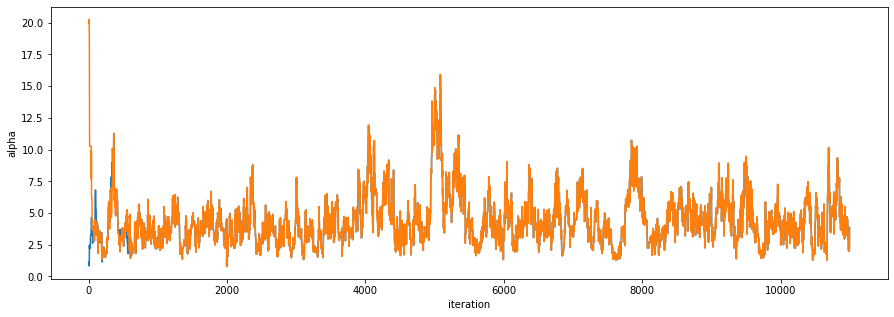

In [176]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

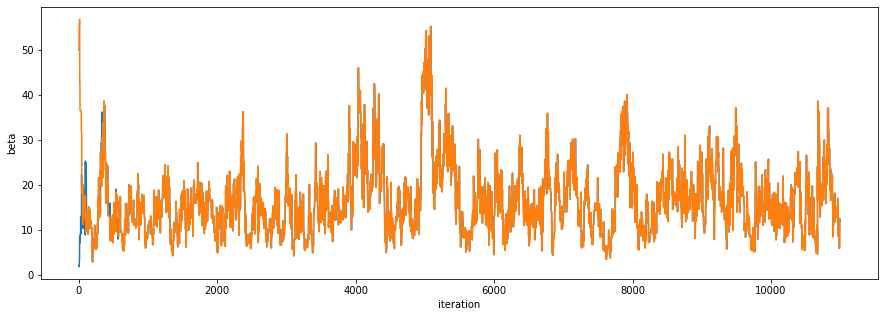

In [177]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

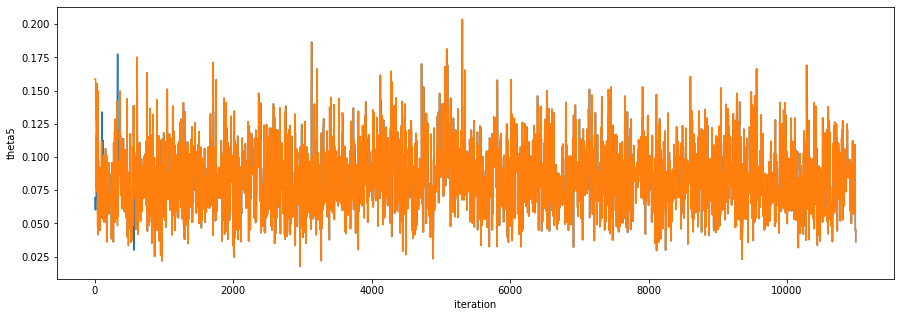

In [178]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df[-20000:], x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Reflective Coupling

In [310]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

# Initial Conditions:

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

# Metropolis-Gibbs, using reflective coupling

params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, equality, reflective_coupling, log_bb, tuning = np.array([0.3, 1.1] + [0.01] * 15), k = 1000, maximum_iteration = 10000)


10000


In [306]:
chain1_df = pd.DataFrame(params_x, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain2_df = pd.DataFrame(params_y, columns = ['alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9', 'theta10', 'theta11', 'theta12', 'theta13', 'theta14', 'theta15'])
chain1_df = chain1_df.reset_index().rename(columns = {'index': 'iteration'})
chain2_df = chain2_df.reset_index().rename(columns = {'index': 'iteration'})

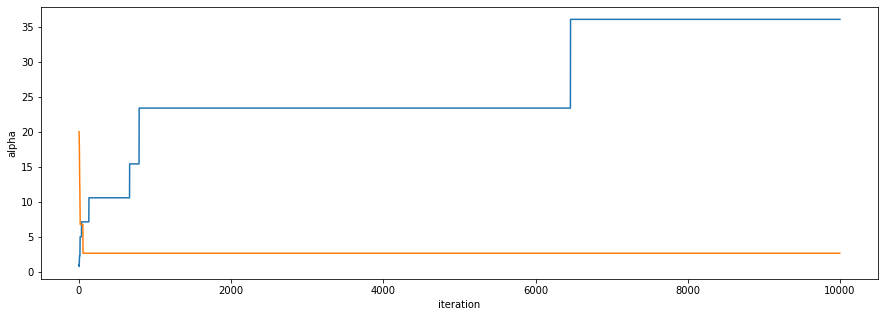

In [307]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'alpha', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

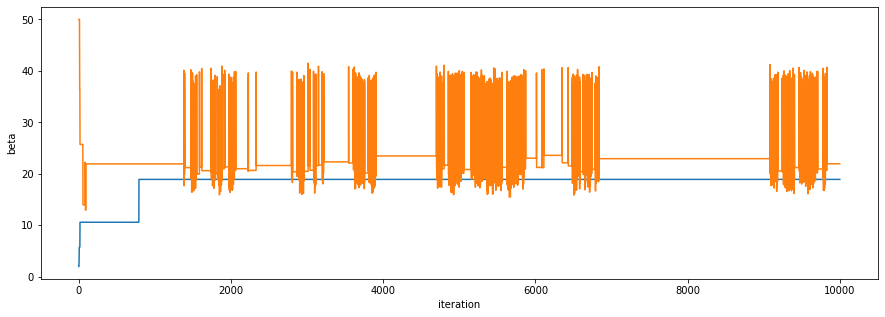

In [311]:
# Orange is the y chain

fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'beta', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

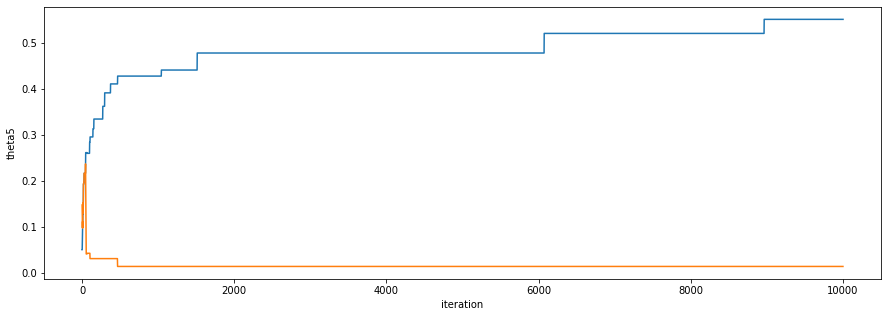

In [309]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.lineplot(data = chain1_df, x = 'iteration', y = 'theta5', ax = ax)
sns.lineplot(data = chain2_df, x = 'iteration', y = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

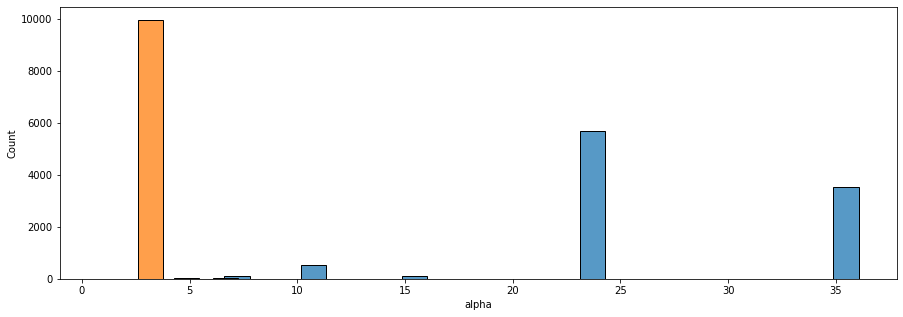

In [301]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.histplot(data = chain1_df, x = 'alpha', ax = ax)
sns.histplot(data = chain2_df, x = 'alpha', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

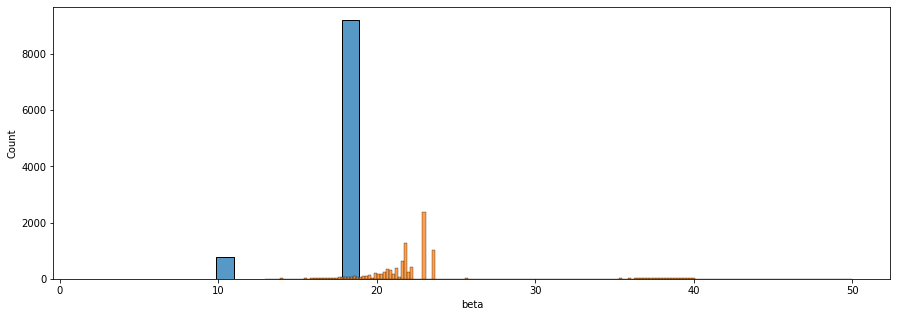

In [302]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.histplot(data = chain1_df, x = 'beta', ax = ax)
sns.histplot(data = chain2_df, x = 'beta', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

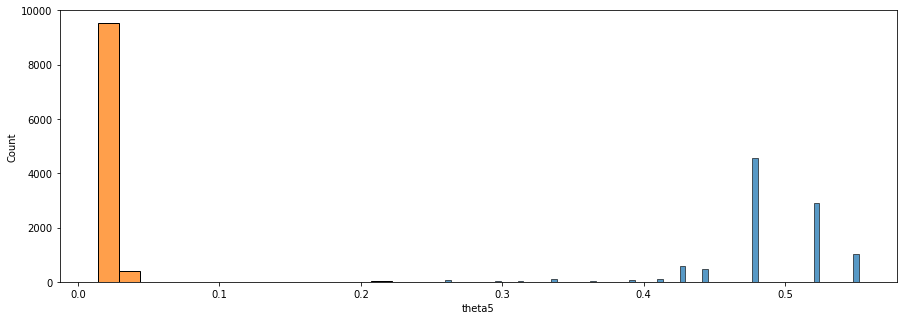

In [304]:
fig, ax = plt.subplots(figsize = (15, 5))

sns.histplot(data = chain1_df, x = 'theta5', ax = ax)
sns.histplot(data = chain2_df, x = 'theta5', ax = ax)

#ax.set_xlim(0, 1000000)
plt.show()

# Meeting Time

In [152]:
n = data1['n'].to_numpy()
y = data1['y'].to_numpy()
data = [y, n]

a_1 = 1
b_1 = 2
theta_1 = np.random.beta(y + a_1, n - y + b_1, 15)

a_2 = 20
b_2 = 50
theta_2 = np.random.beta(y + a_2, n - y + b_2, 15)

x_init = np.append([a_1, b_1], theta_1)
y_init = np.append([a_2, b_2], theta_2)

params, mu, tuning, c, iteration, rate = adaptive_metro2(data, x_init, log_bb, max_iteration = 100000)

100000


In [153]:
iteration_params = []

for i in range(100):

    lamb = tuning + 0.01
    
    params_x, params_y, iteration = coupled_metropolis2(data, x_init, y_init, equality, maximal_coupling, log_bb, tuning = np.exp(2 * c) * lamb, k = 10000)
    iteration_params.append((params_x, params_y, iteration))


138
710
123
241
179
187
167
97
165
93
128
184
181
171
190
97
137
172
117
136
128
52
87
104
315
116
287
98
121
117
213
66
280
206
265
121
122
73
122
92
95
140
70
81
204
233
152
172
249
159
122
70
128
135
127
70
56
98
108
184
328
166
180
97
204
100
135
69
60
144
125
164
241
211
117
70
211
202
100
229
273
79
339
184
105
171
94
71
246
172
209
185
224
170
187
85
204
76
205
76


In [154]:
meeting_times = []
for _, _, meeting in iteration_params:
    meeting_times.append(meeting)


(array([35., 33., 24.,  5.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([ 52. , 117.8, 183.6, 249.4, 315.2, 381. , 446.8, 512.6, 578.4,
        644.2, 710. ]),
 <BarContainer object of 10 artists>)

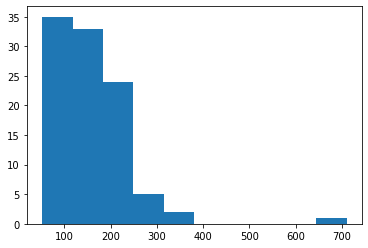

In [155]:
plt.hist(meeting_times)

In [156]:
np.mean(meeting_times)

157.59